# Assignment 5

In [2]:
from matplotlib import pyplot as plt
import a5_utils
import a4_utils
import numpy as np
from PIL import Image
import cv2

## Exercise1

### Task b

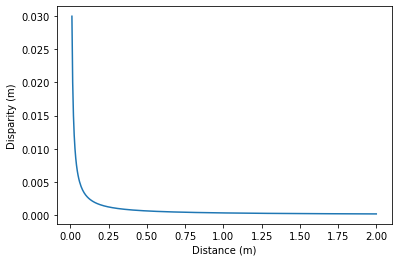

In [3]:
#Calculate the disparity for a range of distances pz
def task_b(f = 2.5e-3, T = 0.12):
    pz = np.linspace(0.01, 2, 400)
    disparities = f*T/pz
    plt.plot(pz, disparities)
    plt.xlabel('Distance (m)')
    plt.ylabel('Disparity (m)') #TODO: check if this is correct
    plt.show()

task_b()

## Exercise 2

# Task b

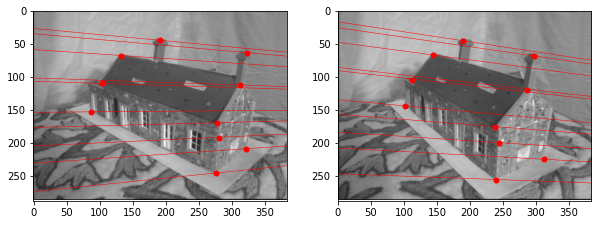

In [4]:
def fundamental_matrix(pts1, pts2):
    #Normalize the points, so that the centroid is at the origin and on average the distance from the origin is sqrt(2), get the transformation matrix.
    pts1, T1 = a5_utils.normalize_points(pts1)
    pts2, T2 = a5_utils.normalize_points(pts2)

    correspondences = np.concatenate((pts1[:,0:2], pts2[:,0:2]), axis=1)

    #Create the matrix A
    A = []
    for u, v, u_, v_ in (correspondences):
        A.append([u*u_, u_*v, u_, u*v_, v*v_, v_, u, v, 1])
    
    A = np.array(A)

    #Compute the SVD of A https://www.youtube.com/watch?v=nbBvuuNVfco
    U, D, VT = np.linalg.svd(A)

    #The last column of V (last row of V.T) (eigenvector v9) is the solution to the equation Av = 0
    #Transforming the last eigenvector v9 in a 3 × 3 fundamental matrix F
    F = VT[-1].reshape(3,3)

    #Enforce the rank 2 constraint
    #Decomposing the fundamental matrix F into UDV^T
    U, D, VT = np.linalg.svd(F)
    #Setting the smallest eigenvalue to zero
    D[2] = 0
    #Reconstructing the fundamental matrix F
    F = np.dot(U, np.dot(np.diag(D), VT))

    #Transforming the fundamental matrix F back to the original coordinate system
    F = np.dot(T2.T, np.dot(F, T1))

    return F

    
def task_b():
    correspondences = np.loadtxt("data\epipolar\house_points.txt")
    I1 = np.asarray(Image.open("data\epipolar\house1.jpg").convert("L")).astype(np.float64) / 255
    I2 = np.asarray(Image.open("data\epipolar\house2.jpg").convert("L")).astype(np.float64) / 255

    #Store correspondences of the first image into pts1 and second into pts2
    pts1 = correspondences[:,:2]
    pts2 = correspondences[:,2:]

    #Compute the fundamental matrix F
    F = fundamental_matrix(pts1, pts2)

    #Transfrom the points into homogeneous coordinates
    h_pts1 = np.hstack((pts1, np.ones((pts1.shape[0],1))))
    h_pts2 = np.hstack((pts2, np.ones((pts2.shape[0],1))))

    #Compute the epipolar lines for each point
    L2 = []
    for row in h_pts1:
        L2.append(np.dot(F, row))
    L1 = []
    for row in h_pts2:
        L1.append(np.dot(F.T, row))

    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.imshow(I1, cmap="gray")
    #Draw the epipolar lines
    for line in L1:
        a5_utils.draw_epiline(line, I1.shape[0], I1.shape[1])
    #Plot the points
    plt.plot(pts1[:,0], pts1[:,1], 'r.', markersize=10)

    plt.subplot(1,2,2)
    plt.imshow(I2, cmap="gray")
    #Draw the epipolar lines
    for line in L2:
        a5_utils.draw_epiline(line, I2.shape[0], I2.shape[1])
    #Plot the points
    plt.plot(pts2[:,0], pts2[:,1], 'r.', markersize=10)

    plt.show()

task_b()

## Task c

In [5]:
def reprojection_error(F, point1, point2):
    #Transform into homogeneous coordinates
    h_point1 = np.append(point1, [1])
    h_point2 = np.append(point2, [1])

    #Calculate the epipolar lines
    l1 = np.dot(F.T, h_point2)
    l2 = np.dot(F, h_point1)

    #Calculate the pependicular distances
    distance1 = np.abs(np.sum(l1*h_point1)) / np.sqrt(l1[0]**2 + l1[1]**2)
    distance2 = np.abs(np.sum(l2*h_point2)) / np.sqrt(l2[0]**2 + l2[1]**2)

    #Return the average
    return  (distance2+distance1)/2



def task_c():
    correspondences = np.loadtxt("data\epipolar\house_points.txt")
    I1 = np.asarray(Image.open("data\epipolar\house1.jpg").convert("L")).astype(np.float64) / 255
    I2 = np.asarray(Image.open("data\epipolar\house2.jpg").convert("L")).astype(np.float64) / 255

    #Store correspondences of the first image into pts1 and second into pts2
    pts1 = correspondences[:,:2]
    pts2 = correspondences[:,2:]

    #Compute the fundamental matrix F
    F = fundamental_matrix(pts1, pts2)

    #PART ONE
    print(reprojection_error(F, [85,233], [67,219]))


    #PART TWO
    errors = []
    for x1, y1, x2, y2 in correspondences:
        errors.append(reprojection_error(F, [x1,y1], [x2,y2]))

    print(np.average(errors))

task_c()

0.14674365570458087
0.33091336980543307


## Task d

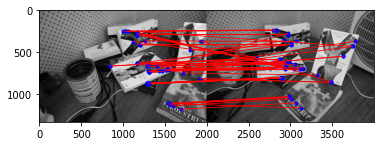

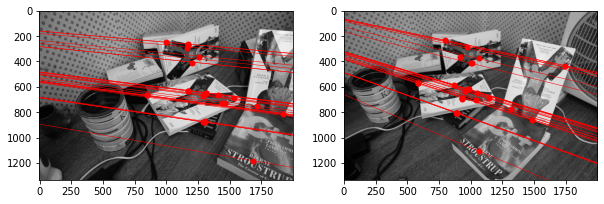

In [16]:
def fundamental_ransac(correspondences, samples = 8, error = 1, iterations = 1000):
    #Here we will sotre the largest number of inliers and the corresponding model
    mostInliers = []
    bestF = []
    #We start the ransac loop
    for i in range(0, iterations):
        #Select 4 random correpondences
        np.random.shuffle(correspondences)
        randCorr = correspondences[:samples]
        #Calculate the F for the random correspondences
        pts1 = randCorr[:,0:2]
        pts2 = randCorr[:,2:4]
        F = fundamental_matrix(pts1, pts2)
        #Calculate the error for all the correspondences
        inliers = []
        for corr in correspondences:
            if(reprojection_error(F, corr[0:2], corr[2:4]) < error):
                inliers.append(corr)
        #If we have more inliers than the previous best model, we update the best model
        if(len(inliers) > len(mostInliers)):
            mostInliers = inliers
            bestF = F

    return bestF, np.asarray(mostInliers)




def task_d():
    #Load the images
    I1 = cv2.cvtColor(cv2.imread("data\desk\DSC02638.JPG"), cv2.COLOR_BGR2GRAY)
    I2 = cv2.cvtColor(cv2.imread("data\desk\DSC02640.JPG"), cv2.COLOR_BGR2GRAY)

    #Find correspondences using cv2
    orb = cv2.ORB_create()

    kp1 = orb.detect(I1, None)
    kp2 = orb.detect(I2, None)

    kp1, des1 = orb.compute(I1, kp1)
    kp2, des2 = orb.compute(I2, kp2)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1, des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key=lambda x: x.distance)

    #Get the pixel coordinates for each image
    pts1 = np.asarray([kp1[mat.queryIdx].pt for mat in matches[:60]])
    pts2 = np.asarray([kp2[mat.trainIdx].pt for mat in matches[:60]])

    a4_utils.display_matches(I1, pts1, I2, pts2)

    correspondences = np.hstack((pts1,pts2))
    
    F, corr = fundamental_ransac(correspondences)

    pts1 = np.asarray(corr[:,:2])
    pts2 = np.asarray(corr[:,2:4])

    #Transfrom the points into homogeneous coordinates
    h_pts1 = np.hstack((pts1, np.ones((pts1.shape[0],1))))
    h_pts2 = np.hstack((pts2, np.ones((pts2.shape[0],1))))

    #Compute the epipolar lines for each point
    L2 = []
    for row in h_pts1:
        L2.append(np.dot(F, row))
    L1 = []
    for row in h_pts2:
        L1.append(np.dot(F.T, row))

    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.imshow(I1, cmap="gray")
    #Draw the epipolar lines
    for line in L1:
        a5_utils.draw_epiline(line, I1.shape[0], I1.shape[1])
    #Plot the points
    plt.plot(pts1[:,0], pts1[:,1], 'r.', markersize=10)

    plt.subplot(1,2,2)
    plt.imshow(I2, cmap="gray")
    #Draw the epipolar lines
    for line in L2:
        a5_utils.draw_epiline(line, I2.shape[0], I2.shape[1])
    #Plot the points
    plt.plot(pts2[:,0], pts2[:,1], 'r.', markersize=10)

    plt.show()

task_d()

# Exercise 3

## Task a

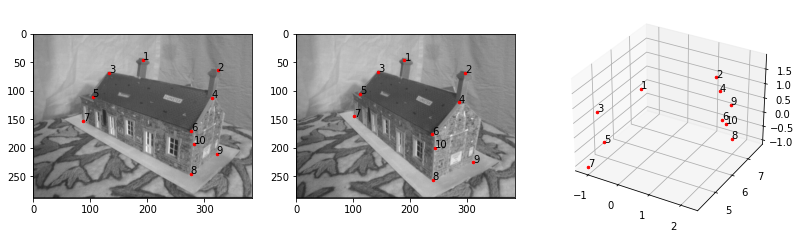

In [7]:
def triangulate(correspondences, P1, P2):
    points3D = []
    for x1, y1, x2, y2 in correspondences:
        #Transform homogenous coordinates vector into array form
        pts1 = np.array([[0, -1, y1], [1, 0, -x1], [-y1, x1, 0]])
        pts2 = np.array([[0, -1, y2], [1, 0, -x2], [-y2, x2, 0]])

        #Calculate the Ax matrices (Product of [x]P)
        A1 = np.dot(pts1, P1)
        A2 = np.dot(pts2, P2)

        #Combine the first 2 lines of A1 and A2 into A matrix
        A = np.append(A1[:2], A2[:2], axis=0)

        #Calculate the SVD of A
        U, D, VT = np.linalg.svd(A)

        #Get the eigen vector (last column of V = the last row of VT) that has the lowest eigenvalue (last value of diagonal matrix D)
        p3d = VT[-1]

        #Normalize the point and remove the extra 1
        p3d = (p3d / p3d[-1])[:3]

        # Add the point to all other 3d points
        points3D.append(p3d)

    return np.array(points3D)






def task_a():
    corr = np.loadtxt("data\epipolar\house_points.txt")
    P1 = np.loadtxt("data\epipolar\house1_camera.txt")
    P2 = np.loadtxt("data\epipolar\house2_camera.txt")
    I1 = np.asarray(Image.open("data\epipolar\house1.jpg").convert("L")).astype(np.float64) / 255
    I2 = np.asarray(Image.open("data\epipolar\house2.jpg").convert("L")).astype(np.float64) / 255

    points3D = triangulate(corr, P1, P2)

    #Dot product between points3D and T for plotting
    T = np.array([[-1,0,0], [0,0,1], [0,-1,0]])

    points3D = np.dot(points3D, T)

    # Set up a figure twice as tall as it is wide
    fig = plt.figure(figsize=plt.figaspect(0.3))

    # First subplot
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(I1, cmap="gray")
    ax.plot(corr[:,0], corr[:,1], 'r.', markersize=5)
    for i in range(0, corr[:,0].shape[0]):
        plt.text(corr[i,0], corr[i,1], i+1)

    # Second subplot
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(I2, cmap="gray")
    ax.plot(corr[:,2], corr[:,3], 'r.', markersize=5)
    for i in range(0, corr[:,2].shape[0]):
        plt.text(corr[i,2], corr[i,3], i+1)

    # Third subplot (3d)
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.plot(points3D[:,0],points3D[:,1],points3D[:,2],  "r.", markersize=5)
    for i in range(0, points3D[:,0].shape[0]):
        ax.text(points3D[i,0], points3D[i,1], points3D[i,2], i+1)

    plt.show()

task_a()